In [42]:
import datetime

import pandas as pd
import spacy
import re
import string
import numpy as np

from matplotlib import cm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

from spacy.tokens import Token
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import gensim
from gensim import corpora, models
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.coherencemodel import CoherenceModel
from lda2vec import preprocess, Corpus


import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from ipywidgets import interact

import nltk
from nltk.corpus import stopwords

from sklearn.decomposition import PCA

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

import enchant
pd.set_option('display.max_rows', 500)

ModuleNotFoundError: No module named 'lda2vec'

In [43]:
dict_check = enchant.Dict("en_US")

#### Importing the file ####
Path="src/"
Filename='projects_Preprocessed.csv'
df=pd.read_csv(Path+Filename)

Cat_File="category_hier.csv"
Cat_data=pd.read_csv(Path+Cat_File)

varcluster_file="variable_clusters.csv"
varcluster=pd.read_csv(Path+varcluster_file)

manualtag=pd.read_csv(Path+'SamplesManualTagger.csv')


varcluster_info=pd.read_csv(Path+'variable_clusters_info_v2.csv')

df=df[df['Translates']!="The goal of the Heisenberg Program is to enable outstanding scientists who fulfill all the requirements for a long-term professorship to prepare for a scientific leadership role and to work on further research topics during this time. In pursuing this goal, it is not always necessary to choose and implement project-based procedures. For this reason, in the submission of applications and later in the preparation of final reports - unlike other support instruments - no 'summary' of project descriptions and project results is required. Thus, such information is not provided in GEPRIS."]

## Filtering the null abstracts & short description
df=df[(pd.isnull(df.PreProcessedDescription)==False) & (df.PreProcessedDescription.str.strip()!='abstract available')& (df.PreProcessedDescription.str.len()>100) & (pd.isnull(df["SubjectArea"])==False)]

# Striping the category column
Cat_data.Category=Cat_data.Category.str.strip()

## Merging the high level category information

df=df.merge(Cat_data[["File_Categories","Category"]], how="left", left_on="SubjectArea", right_on="File_Categories")


In [3]:
#dummies=pd.get_dummies(merged_data['Category'])
#merged_data=pd.concat([merged_data,dummies], axis=1,ignore_index=False)

In [3]:
df.columns

Index(['Name', 'SubUrl', 'FundingFrom', 'FundingEnd', 'SubjectArea',
       'Institution', 'Description', 'Translates', 'Name_Translated',
       'PreProcessedDescription', 'File_Categories', 'Category'],
      dtype='object')

In [4]:
# TF IDF Conversion

vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
review_vectors = vectorizer.fit_transform(df["PreProcessedDescription"])
features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())

features_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)
merged_data=pd.concat([df,features_df], axis=1,ignore_index=False)

#wordslist=merged_data.columns.tolist()[len(df.columns)+6:]

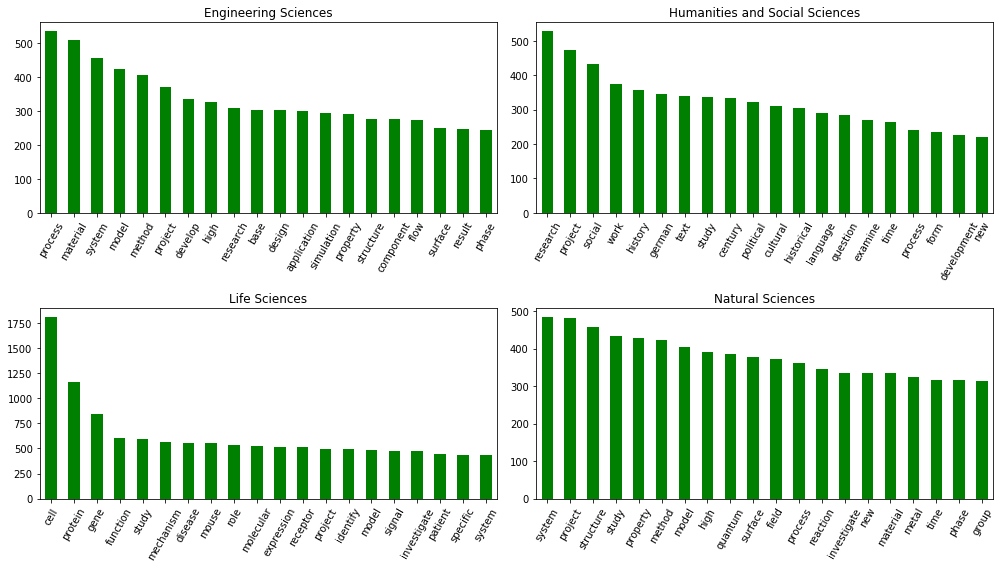

In [5]:
wordslist=merged_data.columns.tolist()[len(df.columns)+2:]

plt.subplots(figsize=(14,8)) 
i=1
for cat,bucket in merged_data.groupby('Category'):
    
    plt.subplot(2,2,i)
    bucket[wordslist].sum().sort_values(ascending=False).head(20).plot(kind='bar',color='green')
    plt.title(cat)
    plt.xticks(rotation=60)
    
    i=i+1
    plt.tight_layout()

In [19]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

def make_bigram(inputlist):
    bigram = Phrases(inputlist, min_count=1, threshold=1,delimiter=b' ')
    bigram_phraser = Phraser(bigram)
    new_list=[]
    for sent in inputlist:
        new_list.append(bigram_phraser[sent])
    return new_list

def buildLDA(processed_docs, ip_num_topics=4):
    dictionary = gensim.corpora.Dictionary(processed_docs)
    dictionary.filter_extremes(no_below=5, no_above=0.1, keep_n=1000)
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

    tfidf = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]

    #lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=ip_num_topics, id2word=dictionary, passes=4, workers=4, 
    #                                             eta=[0.001]*len(dictionary.keys()), alpha =.005*ip_num_topics)
    
    return dictionary,bow_corpus,corpus_tfidf#, lda_model_tfidf


def LDAtopicSummary(model, displaysubplot=[2,2]):
    for idx, topic in model.print_topics(-1):
        print('Topic: {} Word: {}'.format(idx, topic))
        
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        #print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords',"Text"]
    return(sent_topics_df)


## 1.1 Word Embedding

In [51]:
## Word Embeddings Functions

## Generate the tagged documents (tagging based on the category column)
def create_tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

## Generate the tagged documents (each record in single tag )
def create_tagged_document_based_on_tags(list_of_list_of_words, tags):
    for i in range(len(list_of_list_of_words)):
        yield gensim.models.doc2vec.TaggedDocument(list_of_list_of_words[i], [tags[i]])

def make_bigram(inputlist):
    bigram = Phrases(inputlist, min_count=3, threshold=1,delimiter=b' ')
    bigram_phraser = Phraser(bigram)
    new_list=[]
    for sent in inputlist:
        new_list.append(bigram_phraser[sent])
    return new_list        
        
## Generate output using the word embedding model prediction - takes long time to regenerate
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs#.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [52]:
## creating a tagged document
DescDict=make_bigram([[x for x in str(i).split()] for i in df.PreProcessedDescription])

#tagged_value_tags = list(create_tagged_document_based_on_tags(DescDict, df.Category.tolist()))
tagged_value = list(create_tagged_document(DescDict))

In [53]:
print(str(datetime.datetime.now()),'Started')

# Init the Doc2Vec model
model = gensim.models.Word2Vec(DescDict,size=50, min_count=3, alpha = 0.02, sg=1,seed=42, workers=4)

#### Hyper parameter ####


print(str(datetime.datetime.now()),'Completed')

2020-02-27 19:26:43.901302 Started
2020-02-27 19:29:31.537119 Completed


In [57]:
## Validating the model response for random words 

modelchecked=model
target_word='life'
print('target_word: %r model: %s similar words:' % (target_word, modelchecked))
for i, (word, sim) in enumerate(modelchecked.wv.most_similar(target_word, topn=20), 1):
    print('    %d. %.2f %r' % (i, sim, word))

target_word: 'life' model: Word2Vec(vocab=165230, size=50, alpha=0.02) similar words:
    1. 0.80 'renew'
    2. 0.79 'thing'
    3. 0.79 'everyday life'
    4. 0.78 'sacrifice'
    5. 0.77 'criminal'
    6. 0.77 'constantly'
    7. 0.77 'man'
    8. 0.77 'cope'
    9. 0.77 'encounter'
    10. 0.76 'danger'
    11. 0.76 'beginning'
    12. 0.76 'human being'
    13. 0.76 'human life'
    14. 0.76 'precarious'
    15. 0.76 'right'
    16. 0.76 'reject'
    17. 0.76 'last'
    18. 0.76 'continuity'
    19. 0.76 'decisively'
    20. 0.76 'social change'


### LDA

In [10]:
docs=make_bigram(df["PreProcessedDescription"].map(preprocess))
print(str(len(docs))+' docs in input')

51033 docs in input


In [24]:
topics=[4,8,12,16,18,20,30,40,50]
coherence_score=[]

dictionary,bow_corpus,corpus_tfidf =buildLDA(docs )


for ip_num_topics in topics:
    
    lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=ip_num_topics, id2word=dictionary, passes=4, workers=4, 
                                                 eta=[0.001]*len(dictionary.keys()), alpha =.005*ip_num_topics, random_state=42)
    # Compute Coherence Score using c_v
    coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=docs, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('Topic :',ip_num_topics ,'Coherence Score: ', coherence_lda)
    coherence_score.append(coherence_lda)

Topic : 30 Coherence Score:  0.37468812401364604
Topic : 40 Coherence Score:  0.3119178830973567
Topic : 50 Coherence Score:  0.2821487967013685


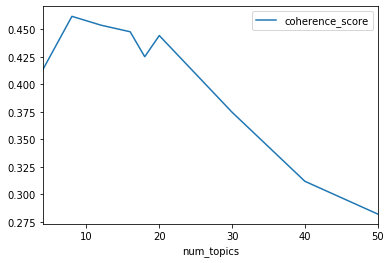

In [38]:
pd.DataFrame({'num_topics':topics,'coherence_score':coherence_score}).plot(x='num_topics',y='coherence_score')

In [39]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=4, workers=4, 
                                                 eta=[0.001]*len(dictionary.keys()), alpha =.005*ip_num_topics, random_state=42)

In [40]:
LDAtopicSummary(lda_model_tfidf)

Topic: 0 Word: 0.023*"protein" + 0.009*"complex" + 0.008*"enzyme" + 0.008*"infection" + 0.007*"bacteria" + 0.007*"membrane" + 0.007*"cluster" + 0.007*"gene" + 0.006*"virus" + 0.006*"receptor"
Topic: 1 Word: 0.011*"material" + 0.008*"application" + 0.007*"property" + 0.006*"component" + 0.006*"design" + 0.005*"measurement" + 0.005*"simulation" + 0.005*"control" + 0.005*"field" + 0.005*"device"
Topic: 2 Word: 0.006*"practice" + 0.005*"research project" + 0.005*"question" + 0.005*"hand" + 0.005*"social" + 0.005*"change" + 0.005*"network" + 0.005*"concept" + 0.005*"focus" + 0.005*"state"
Topic: 3 Word: 0.010*"datum" + 0.008*"change" + 0.008*"long term" + 0.007*"record" + 0.007*"variability" + 0.007*"area" + 0.006*"climate change" + 0.006*"region" + 0.006*"community" + 0.006*"climate"
Topic: 4 Word: 0.013*"real time" + 0.012*"tumor" + 0.011*"library" + 0.011*"patient" + 0.010*"joint" + 0.007*"candidate" + 0.006*"information" + 0.006*"attention" + 0.006*"language" + 0.006*"stimulus"
Topic: 5

In [41]:
pyLDAvis.gensim.prepare(lda_model_tfidf, bow_corpus, dictionary=lda_model_tfidf.id2word)

/Users/balaji/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.062250 -0.088709       1        1  18.849632
2     -0.076442  0.079037       2        1  15.076308
6      0.168493  0.022522       3        1  12.218894
7     -0.027798 -0.103293       4        1  12.043538
0      0.132671 -0.015233       5        1   9.503323
3     -0.016009  0.028267       6        1   9.451662
8     -0.094571  0.045991       7        1   8.596263
9     -0.073226 -0.004312       8        1   5.130307
4      0.014161  0.042709       9        1   4.694493
5      0.034971 -0.006978      10        1   4.435578, topic_info=    Category         Freq                  Term        Total  loglift  logprob
273  Default  3729.000000               protein  3729.000000  30.0000  30.0000
609  Default  1762.000000                 plant  1762.000000  29.0000  29.0000
391  Default  1277.000000               channel  1277.000000  28.0000  28.0000
716  Default  2028.000000               patient  2028.000000  27.0000  27.0000
57   Default  1978.000000              particle  1978.000000  26.0000  26.0000
523  Default  1058.000000                 tumor  1058.000000  25.0000  25.0000
286  Default  1611.000000                 image  1611.000000  24.0000  24.0000
764  Default   854.000000             real time   854.000000  23.0000  23.0000
528  Default  1141.000000                  text  1141.000000  22.0000  22.0000
760  Default  2014.000000                  gene  2014.000000  21.0000  21.0000
604  Default  1479.000000                 mouse  1479.000000  20.0000  20.0000
203  Default  2073.000000               disease  2073.000000  19.0000  19.0000
533  Default   692.000000         research unit   692.000000  18.0000  18.0000
940  Default  1236.000000           mouse model  1236.000000  17.0000  17.0000
62   Default  2449.000000                theory  2449.000000  16.0000  16.0000
59   Default   870.000000               quantum   870.000000  15.0000  15.0000
927  Default   693.000000      transition metal   693.000000  14.0000  14.0000
962  Default  1086.000000               imaging  1086.000000  13.0000  13.0000
225  Default  1449.000000              compound  1449.000000  12.0000  12.0000
770  Default  1122.000000                enzyme  1122.000000  11.0000  11.0000
423  Default   792.000000                 joint   792.000000  10.0000  10.0000
893  Default   985.000000                ligand   985.000000   9.0000   9.0000
216  Default  1108.000000        research group  1108.000000   8.0000   8.0000
199  Default  2922.000000               surface  2922.000000   7.0000   7.0000
990  Default   658.000000               library   658.000000   6.0000   6.0000
261  Default  1011.000000             infection  1011.000000   5.0000   5.0000
731  Default  1220.000000                 metal  1220.000000   4.0000   4.0000
86   Default  1747.000000                  flow  1747.000000   3.0000   3.0000
781  Default  1391.000000              receptor  1391.000000   2.0000   2.0000
505  Default  1142.000000              language  1142.000000   1.0000   1.0000
501   Topic1   779.613770               machine   839.002441   1.5953  -5.6049
222   Topic1   672.990662           solid state   772.108276   1.5313  -5.7519
599   Topic1   555.271973     material property   639.528992   1.5274  -5.9442
403   Topic1   580.746704               crystal   728.427246   1.4421  -5.8993
910   Topic1   508.193481             composite   646.410706   1.4281  -6.0328
842   Topic1   446.705261                 speed   595.055603   1.3819  -6.1618
287   Topic1   693.101501          optimization   928.027588   1.3768  -5.7225
988   Topic1   419.684875              accuracy   564.579651   1.3721  -6.2241
808   Topic1   522.457886   project development   704.240723   1.3701  -6.0051
958   Topic1   633.949524        magnetic field   858.010071   1.3660  -5.8117
602   Topic1   518.996521          time resolve   711.998901   1.3525 